# Word2Vec

* w2v from scratch
* training w2v using the date
* start using w2v

In [11]:
pip install gensim -qq

Note: you may need to restart the kernel to use updated packages.


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



In [12]:
pip install datasets -qq

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytorch_lightning torchmetrics -qq

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --user -U nltk -qq

Note: you may need to restart the kernel to use updated packages.


### Imports and data load

In [17]:
import torch
from torch import nn
import nltk
nltk.download('stopwords')

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
import datasets

import text_helper

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
dataset = datasets.load_dataset('tweets_hate_speech_detection')

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

Dataset tweets_hate_speech_detection downloaded and prepared to C:/Users/HOME/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/d8cea5e82c610e1675eee6632345085d81875565ea46d24bdcd5a7f382e335ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Main steps

* Splitting the text into tokens
* Creating a dictionary and getting key characteristics of the text // Создаем словарь и другие вспомогательные характеристики по текстам
* Remove the rare tokens // Убираем редкие токены
* Apply sliding window function to train word2vec // Организуем скользящее окно

Important functions in the file text_helper.py // Реализация в файле text_helper.py

In [7]:
dataset = dataset.map(text_helper.split_tokens) # разбиваем текст на токены

counts, vocab, n_v, id2tok, tok2id = text_helper.get_info(dataset) # получаем словарь и так далее

# counts - сколько раз встречается каждое слово в словаре
# vocab - список слов 
# n_v - количество слов в словаре
# id2tok, tok2id - соответствие слов и их индексов в словаре

dataset = dataset.map(lambda x: text_helper.remove_rare_tokens(x, vocab)) # выкидываем редкие токены

dataset = dataset.map(lambda x: text_helper.windowizer(x, tok2id)) # применяем функцию скользящего окна для обучения word2vec

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

## Constructing the network

To work with a dataset in PyTorch (if we do not use the standard datasets that are already in the library), we need to create a class for the dataset inherited from torch.utils.data.Dataset with the following methods:
* `__init__` - creates class fields (for example, the path to the folder with files with training objects)
* `__len__` - calculation of dataset length
* `__getitem__` - access to dataset object by index.

Для работы с датасетом в PyTorch (если мы не используем стандартные датасеты, которые уже есть в библиотеке) нужно создать класс для датасета, унаследованный от torch.utils.data.Dataset с методами:
* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` - вычисление длины датасета
* `__getitem__` - доступ к объекту датасета по индексу.

In [ ]:
class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

train_dataloader = DataLoader(Word2VecDataset(dataset['train'], vocab_size=n_v),
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=N_LOADER_PROCS)

test_dataloader = DataLoader(Word2VecDataset(dataset['test'], vocab_size=n_v),
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=N_LOADER_PROCS)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


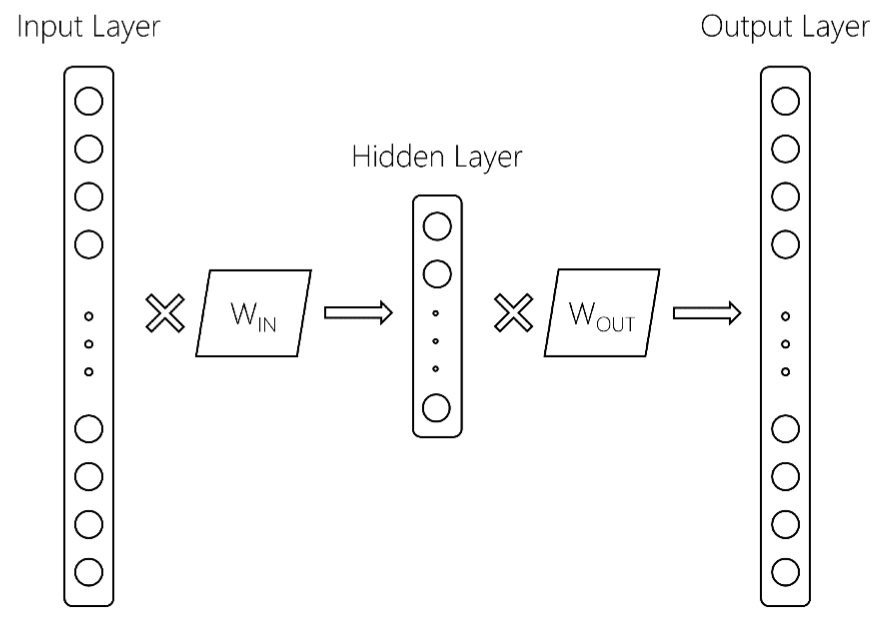

In [16]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size, bias=False)
        self.loss_func = nn.CrossEntropyLoss()

    def forward(self, input, target=None):
        hidden = self.embed(input)
        logits = self.linear(hidden)

        if target is not None:
            loss = self.loss_func(logits, target) # вычисляем ошибку модели
            return logits, loss

        return logits

In [14]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) # вариант градиентного спуска, который мы используем
        return optimizer

    def training_step(self, train_batch, batch_idx): # шаг обучения: вычисляем лосс на батче
        center, context = train_batch
        _, loss = self.model(center, context)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

    def validation_step(self, val_batch, batch_idx): # шаг валидации - аналогичный
        center, context = val_batch
        _, loss = self.model(center, context)
        self.log("val_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25 # number of epochs
LR = 0.001 # learning rate, gradient descent step

In [ ]:
# 2) create module

EMBED_SIZE = 100 # можно и больше

model = Word2Vec(n_v, EMBED_SIZE).to(device) # объявляем сеть, переносим ее на gpu 

module = SimpleModule( # объявляем модуль для обучения сети
    model,
    learning_rate=LR
)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer( # выбираем параметры обучения
    accelerator=accelerator,
    max_epochs=EPOCHS
)

trainer.fit(module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | Word2Vec | 617 K 
-----------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
wordvecs = module.model.linear.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

## Final results

* `get_distance_matrix` - функция для вычисления матрицы расстояний между векторами
* `get_k_similar_words` - функция для вычисления $k$ ближайших по косинусной метрике слов к заданному

In [ ]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric): # матрица расстояний между векторами слов
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10): # k ближайших слов к заданному
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')

for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['day', 'im', 'morn', 'make', 'great', 'happi', 'today', '@user', 'everyon', 'feel'] 

father ['dad', '#fathersday', 'day', 'wish', 'wonder', 'happi', 'enjoy', 'everi', 'love', 'made'] 

school ['first', 'year', 'today', 'look', 'live', 'day', 'two', 'one', 'meet', 'last'] 

hate ['would', 'say', 'peopl', 'talk', 'think', 'much', 'still', 'stop', 'know', 'kill'] 



## Training the constructed architecture on actual data // Обучаем готовую архитектуру на своих данных

In [9]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=dataset['train']['tokens'], size=100, window=5)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
model.wv['father']

array([ 0.40185758, -0.74169105,  0.83735055, -1.0766317 , -0.42887673,
        0.731274  ,  0.3291036 ,  0.7522678 ,  0.8209485 ,  0.45100936,
        0.26501864, -0.9950425 , -1.862852  , -0.21093017,  0.68349814,
        0.23907971,  0.09479083,  0.06679087, -0.52651185, -0.8006161 ,
        0.4302516 ,  0.5954295 ,  0.26226416,  0.46016842, -0.23955607,
        0.08300013,  0.69047725, -0.07234474, -1.3856574 , -0.7219974 ,
       -0.26118955,  0.1351229 ,  0.15781312,  0.36916682, -0.35160837,
       -0.5821945 , -0.79106927, -0.19330546,  0.6335709 ,  0.861371  ,
        0.73780775,  0.304591  ,  0.6520482 , -1.5180519 ,  0.25115395,
        0.00622658, -0.05070041, -0.6752453 ,  1.5437272 , -1.1592396 ,
        0.06645438,  0.15073316, -0.7401898 , -0.2410207 , -0.27310345,
       -1.314389  ,  0.03328351, -0.3492249 ,  0.45478037, -0.6153168 ,
        1.1939151 , -0.7053519 ,  0.5067601 , -0.47305754, -0.78970814,
        0.22615467,  0.6054272 , -0.42884082,  0.35100308, -0.01

In [ ]:
model.most_similar('father')

<ipython-input-18-160a51c678ed>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('father')


[('dad', 0.9944112300872803),
 ('#fathersday', 0.9404805898666382),
 ('wish', 0.9328075051307678),
 ('daddi', 0.9167653322219849),
 ('day', 0.9158835411071777),
 ('#dad', 0.904686689376831),
 ('#father', 0.9006020426750183),
 ('fathersday', 0.8977565765380859),
 ('gift', 0.8963883519172668),
 ('papa', 0.8842581510543823)]

## Using pre-trained models // Используем предобученные модели

In [ ]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2v_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
w2v_vectors['father']

array([-1.2006  ,  0.59454 ,  0.27821 ,  0.86424 ,  0.021296, -1.1184  ,
        1.1299  ,  0.26826 , -0.41652 , -0.22056 ,  0.203   ,  0.57734 ,
       -3.8551  ,  0.58745 , -0.21923 , -0.30499 ,  0.75124 ,  0.31219 ,
        0.29848 , -0.43404 ,  1.0534  ,  0.85965 , -0.90158 , -0.47079 ,
       -0.37878 ], dtype=float32)

In [ ]:
w2v_vectors.most_similar('father')

[('mother', 0.9509678483009338),
 ('daughter', 0.9483673572540283),
 ('husband', 0.9278268814086914),
 ('child', 0.926058292388916),
 ('wife', 0.9247055053710938),
 ('whose', 0.9104864001274109),
 ('grandmother', 0.9046281576156616),
 ('woman', 0.9028054475784302),
 ('birth', 0.8912784457206726),
 ('called', 0.8850919604301453)]

In [ ]:
new_vector = w2v_vectors['queen'] - w2v_vectors['woman'] + w2v_vectors['man']

In [ ]:
w2v_vectors.most_similar(positive=[new_vector])

[('nat', 0.8628743886947632),
 ('man', 0.8274872303009033),
 ('tom', 0.8135090470314026),
 ('val', 0.7990008592605591),
 ('omg', 0.7952776551246643),
 ('ken', 0.7896935343742371),
 ('boom', 0.788312554359436),
 ('bam', 0.7844098210334778),
 ('nina', 0.7789903283119202),
 ('miss', 0.7762444615364075)]